In [42]:
#Import libraries
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata as ad
from scipy.sparse import csr_matrix
import logging
import matplotlib.pyplot as plt
import scipy
import scipy.stats

#sc.settings.set_figure_params(dpi=100)
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = '/Users/laurel/Documents/2019_Winter/Biophysics/data/output.h5ad' #'/Users/garrettwong/Documents/winterY1/systems/data/data/output.h5ad'

scanpy==1.4 anndata==0.6.17 numpy==1.16.2 scipy==1.2.1 pandas==0.24.1 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


# Part I: Data Processing

In [43]:
#Load 10x data
#RNA
adata_rna = sc.read_10x_mtx('/Users/laurel/Documents/2019_Winter/Biophysics/BP205B_2019/data/JY_HG_01_PANC/filtered_gene_bc_matrices/GRCh38',
                            var_names='gene_symbols', cache=True)

... reading from cache file ./cache/Users-laurel-Documents-2019_Winter-Biophysics-BP205B_2019-data-JY_HG_01_PANC-filtered_gene_bc_matrices-GRCh38-matrix.h5ad


In [44]:
#Barcodes
adata_barcodes = sc.read_10x_mtx('/Users/laurel/Documents/2019_Winter/Biophysics/BP205B_2019/data/JY_HG_01_barcodes/',
                                 var_names='gene_symbols', cache=True)

... reading from cache file ./cache/Users-laurel-Documents-2019_Winter-Biophysics-BP205B_2019-data-JY_HG_01_barcodes-matrix.h5ad


In [45]:
#Filter adata_barcodes to just have barcodes called as cells from RNA
adata_barcodes_filtered = adata_barcodes[adata_rna.obs.index,:]
adata_barcodes_filtered

View of AnnData object with n_obs × n_vars = 4535 × 10 
    var: 'gene_ids', 'feature_types'

In [46]:
sc.settings.set_figure_params(dpi=90) #sometimes need to rerun this line for the figures to actually look different

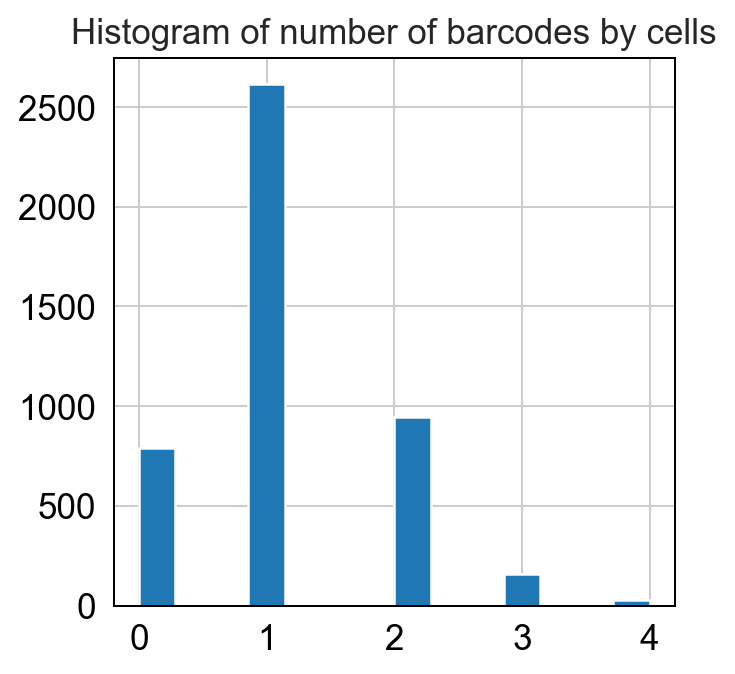

In [47]:
#Histogram of number of barcodes for each cell
non_zero_array = adata_barcodes_filtered.X > 0
barcodes_per_cell = np.sum(non_zero_array.toarray(), axis=1)
plt.hist(barcodes_per_cell, bins='auto')
plt.title("Histogram of number of barcodes by cells")
plt.show()

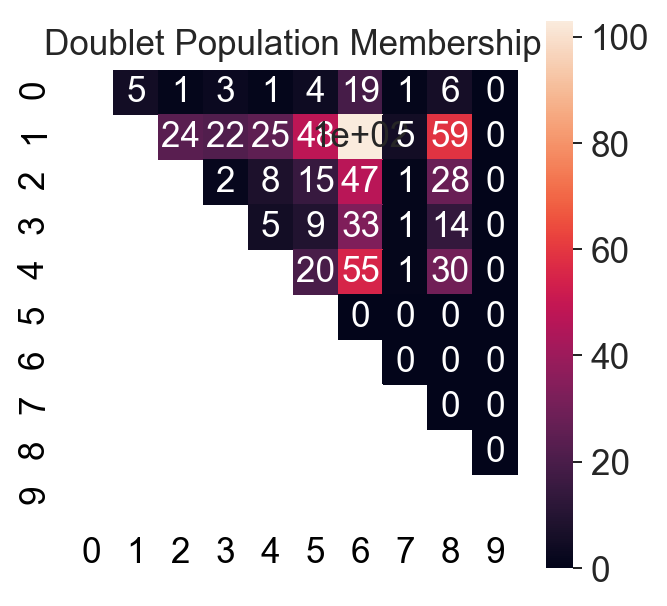

In [48]:
## Messy attempt to check for which pairs of populations the doublets come from
## feel free to delete or modify
adataDF = adata_barcodes_filtered.to_df()
barcodeSets = {}
for cell in np.array(adataDF):
    cellbcs = tuple([i for i,b in enumerate(cell) if b > 0])
    if len(cellbcs) == 2:
        if cellbcs in barcodeSets.keys():
            barcodeSets[cellbcs] += 1
        else:
            barcodeSets[cellbcs] = 1
pairs = barcodeSets.keys()
counts = [ barcodeSets[p] for p in pairs]
bcs = pd.DataFrame({'BC_pairs':list(pairs),'counts':counts})
bcs.sort_values(by='counts',ascending=False)
grid = np.zeros((10,10))
for i in range(0,5):
    for j in range(0,9):
        if (i,j) in barcodeSets.keys():
            grid[i,j] = barcodeSets[(i,j)]
import seaborn as sns
f,ax = plt.subplots()
mask = np.zeros_like(grid)
mask[np.tril_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(grid,annot=True,square=True,mask=mask)
    ax.set_title("Doublet Population Membership")

In [49]:
#Separate multiplets from adata barcode object
zeroes = barcodes_per_cell < 1
print("Discarding", np.sum(zeroes), "cells without a barcode")
multiplets = barcodes_per_cell > 1
adata_barcodes_multiplets = adata_barcodes_filtered[multiplets,:]
adata_barcodes_multiplets_array = adata_barcodes_filtered[multiplets,:].X.toarray()


Discarding 789 cells without a barcode


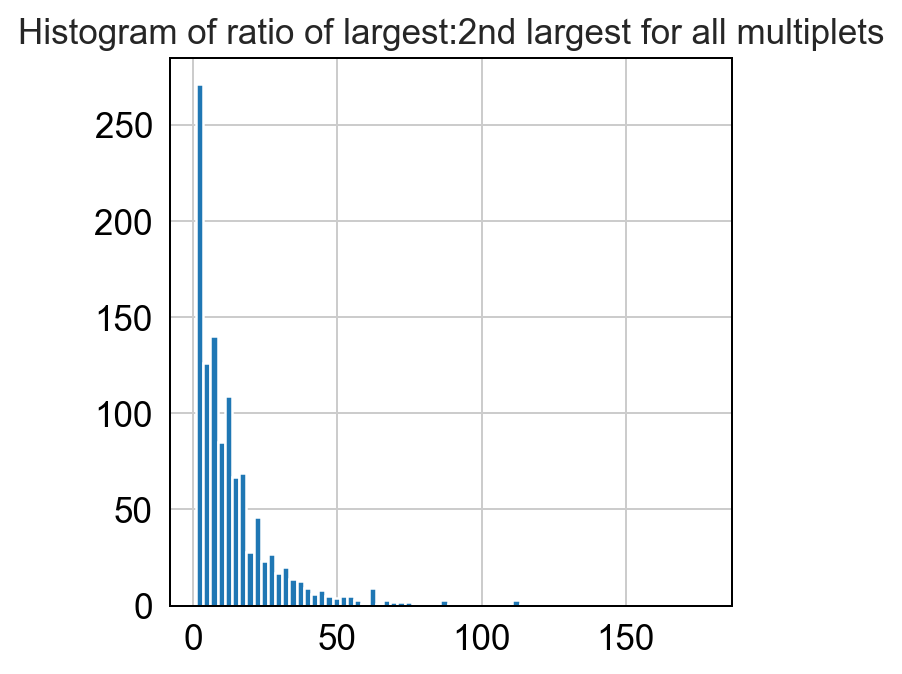

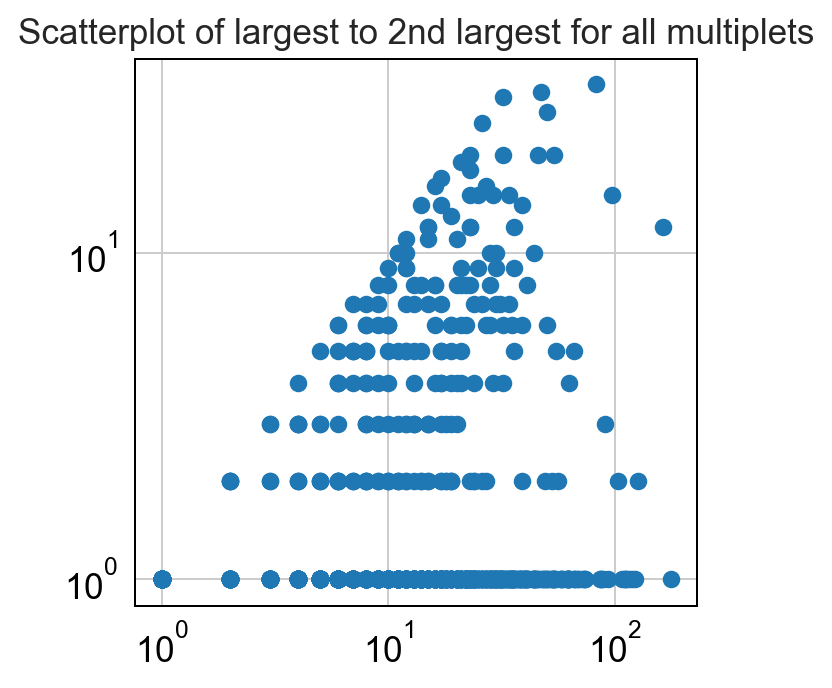

Discarding: 336 cells


/Applications/EMAN2/envs/systemsbio/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [50]:
#Histogram
multiplet_ratio = []
for i in range(adata_barcodes_multiplets_array.shape[0]):
    ratio = sorted(adata_barcodes_multiplets_array[i,:])[-1]/np.sort(adata_barcodes_multiplets_array[i,:])[-2]
    multiplet_ratio.append(ratio)

plt.hist(multiplet_ratio, bins='auto')
plt.title("Histogram of ratio of largest:2nd largest for all multiplets")
plt.show()
#Scatterplot
highest_amt = []
lowest_amt = []
for i in range(adata_barcodes_multiplets_array.shape[0]):
    highest = np.sort(adata_barcodes_multiplets_array[i,:])[-1]
    lowest = np.sort(adata_barcodes_multiplets_array[i,:])[-2]
    highest_amt.append(highest)
    lowest_amt.append(lowest)
plt.scatter(highest_amt,lowest_amt)
plt.loglog()
plt.title("Scatterplot of largest to 2nd largest for all multiplets")
plt.show()

print("Discarding:",np.sum(i <5 for i in multiplet_ratio), "cells")

In [51]:
#Multiplets
multiplets_to_keep =  np.array(multiplet_ratio) >= 5
adata_barcodes_filtered_multiplets = adata_barcodes_multiplets[multiplets_to_keep,]
#Singlets
singlets = barcodes_per_cell == 1
adata_barcodes_filtered_singlets = adata_barcodes_filtered[singlets,]
#Combining
#adata_barcodes_to_keep = adata_barcodes_filtered_singlets.concatenate(adata_barcodes_filtered_multiplets)
barcodes_to_keep = adata_barcodes_filtered_singlets.obs.index.union(adata_barcodes_filtered_multiplets.obs.index)

In [52]:
barcodes_to_keep

Index(['AAACCTGAGAAGGCCT-1', 'AAACCTGAGCACACAG-1', 'AAACCTGCATCACGAT-1',
       'AAACCTGGTGACCAAG-1', 'AAACCTGTCCGTTGCT-1', 'AAACGGGAGGCTCAGA-1',
       'AAACGGGAGTAACCCT-1', 'AAACGGGAGTCTCAAC-1', 'AAACGGGCAAGAAGAG-1',
       'AAACGGGCACAACGCC-1',
       ...
       'TTTGGTTTCCCATTAT-1', 'TTTGGTTTCGTAGGTT-1', 'TTTGTCAAGCCGATTT-1',
       'TTTGTCACACATTCGA-1', 'TTTGTCACAGGAACGT-1', 'TTTGTCACAGGCGATA-1',
       'TTTGTCAGTGGTCTCG-1', 'TTTGTCAGTGTGGTTT-1', 'TTTGTCAGTTACCAGT-1',
       'TTTGTCATCGGCGCTA-1'],
      dtype='object', name=0, length=3410)

In [53]:
#Filtering RNA object
adata_rna = adata_rna[barcodes_to_keep,:]
adata_rna
#Filtering barcode object
adata_barcodes_filtered = adata_barcodes_filtered[barcodes_to_keep,:]
adata_barcodes_filtered

View of AnnData object with n_obs × n_vars = 3410 × 10 
    var: 'gene_ids', 'feature_types'

In [54]:
#Count number of ocurences for each type of population and each replicate

pop_names = adata_barcodes_filtered.var.index 
population_names = []
for i in range(adata_barcodes_filtered.shape[0]):
    max_value = list(adata_barcodes_filtered.X.toarray()[i,:]).index(max(adata_barcodes_filtered.X.toarray()[i,:]))
    population_names.append(pop_names[max_value])

unique, counts = np.unique(population_names, return_counts=True)

print(np.array((unique, counts)).T)

#Assign cell type
dict_pop = {"BXPC3-LVM1-1":"BXPC3", "BXPC3-LVM1-2":"BXPC3", "BXPC3-LVM2-1":"BXPC3","BXPC3-LVM2-2":"BXPC3", "BXPC3-P-1":"BXPC3",
            "BXPC3-P-2":"BXPC3",'PANC1-LVM1-1':"PANC1","PANC1-LVM1-2":"PANC1","PANC1-P-1":"PANC1","PANC1-P-2":"PANC1"}

cell_type = [dict_pop[x] for x in population_names]

[['BXPC3-LVM1-1' '120']
 ['BXPC3-LVM1-2' '185']
 ['BXPC3-LVM2-1' '38']
 ['BXPC3-LVM2-2' '204']
 ['BXPC3-P-1' '1026']
 ['BXPC3-P-2' '69']
 ['PANC1-LVM1-1' '543']
 ['PANC1-LVM1-2' '545']
 ['PANC1-P-1' '251']
 ['PANC1-P-2' '429']]


In [55]:
#Count number of ocurences for each type of population and each replicate

pop_names = adata_barcodes_filtered.var.index 
population_names = []
for i in range(adata_barcodes_filtered.shape[0]):
    max_value = list(adata_barcodes_filtered.X.toarray()[i,:]).index(max(adata_barcodes_filtered.X.toarray()[i,:]))
    population_names.append(pop_names[max_value])

unique, counts = np.unique(population_names, return_counts=True)

print(np.array((unique, counts)).T)

#Assign cell type
dict_pop = {"BXPC3-LVM1-1":"BXPC3", "BXPC3-LVM1-2":"BXPC3", "BXPC3-LVM2-1":"BXPC3","BXPC3-LVM2-2":"BXPC3", "BXPC3-P-1":"BXPC3",
            "BXPC3-P-2":"BXPC3",'PANC1-LVM1-1':"PANC1","PANC1-LVM1-2":"PANC1","PANC1-P-1":"PANC1","PANC1-P-2":"PANC1"}

cell_type = [dict_pop[x] for x in population_names]


[['BXPC3-LVM1-1' '120']
 ['BXPC3-LVM1-2' '185']
 ['BXPC3-LVM2-1' '38']
 ['BXPC3-LVM2-2' '204']
 ['BXPC3-P-1' '1026']
 ['BXPC3-P-2' '69']
 ['PANC1-LVM1-1' '543']
 ['PANC1-LVM1-2' '545']
 ['PANC1-P-1' '251']
 ['PANC1-P-2' '429']]


In [56]:
adata_rna.obs['pop_ID'] = population_names
adata_rna.obs['cell_ID'] = cell_type

In [57]:
adata=adata_rna

In [58]:
adata

AnnData object with n_obs × n_vars = 3410 × 33694 
    obs: 'pop_ID', 'cell_ID'
    var: 'gene_ids'

## Doublet Filtering Complete

In [59]:
#To export matrix as a R friendly object
# cells=pd.DataFrame(adata.obs)
# genes=pd.DataFrame(adata_rna.var)
# expres=pd.DataFrame(adata_rna.X.toarray())
# cells.to_csv("cells.csv")
# genes.to_csv("genes.csv")
# expres.to_csv("expres.csv")

... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical


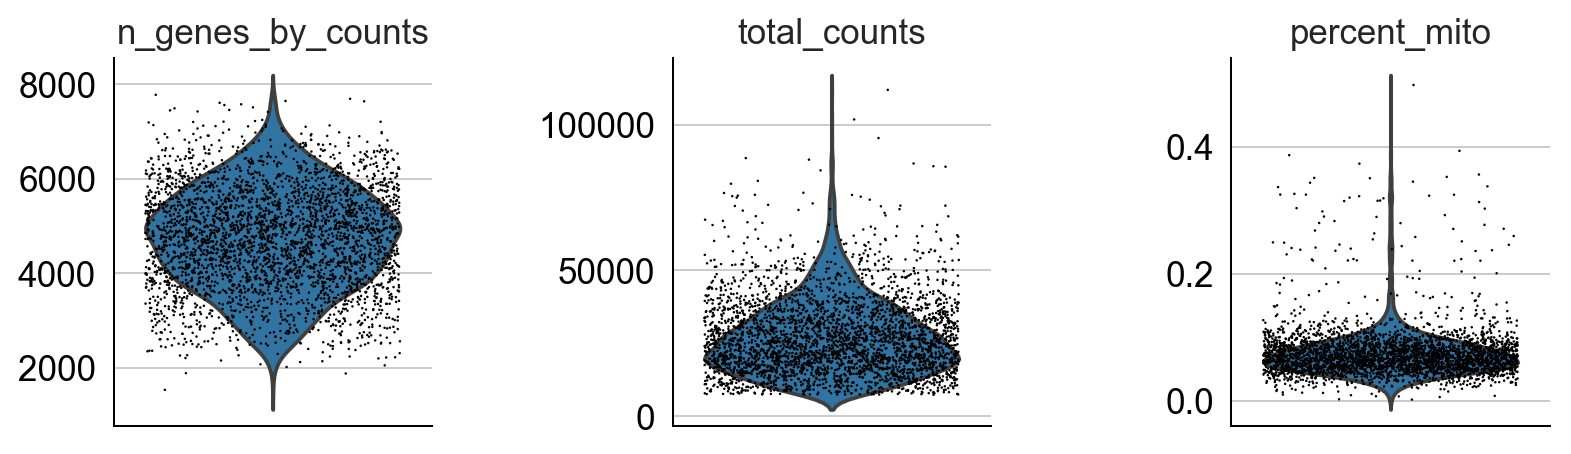

... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical


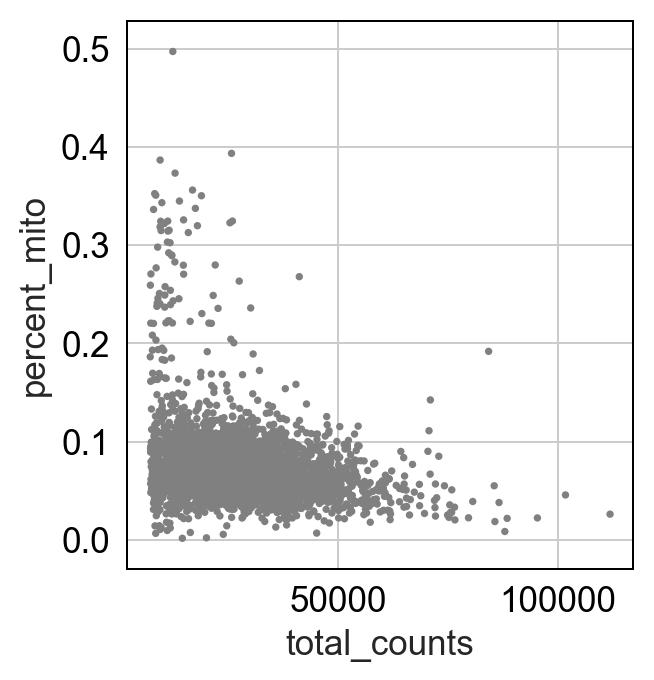

... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical


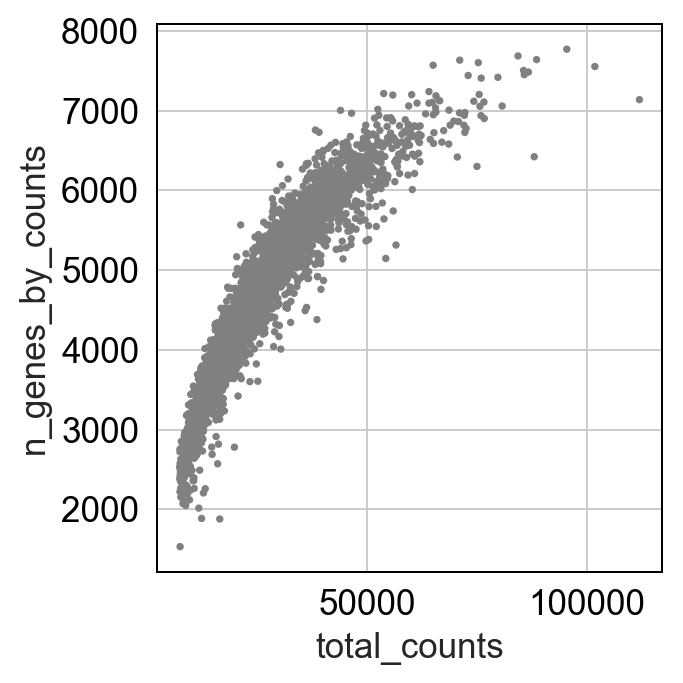

In [60]:
#Calculate quality metrics

# For each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add the total counts per cell as observations-annotation to adata
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
   adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
sc.pp.calculate_qc_metrics(adata, expr_type='counts', var_type='genes',
                        percent_top=(50, 100, 200, 500), inplace=True)

# Plotting
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'percent_mito'],
            jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='percent_mito')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [61]:
# Filtering

#Filter cells by cells with min_genes > 100 and genes that appear in at least 3 cells
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
#Filter cells by cells with % mito < 15
adata = adata[adata.obs['percent_mito'] < 0.15, :]
before_mito =  adata.X.shape[0]
print("Dead cells removed: ", before_mito - adata.X.shape[0])
#Store raw data
adata.raw = adata

filtered out 13269 genes that are detected in less than 3 cells
Dead cells removed:  0


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


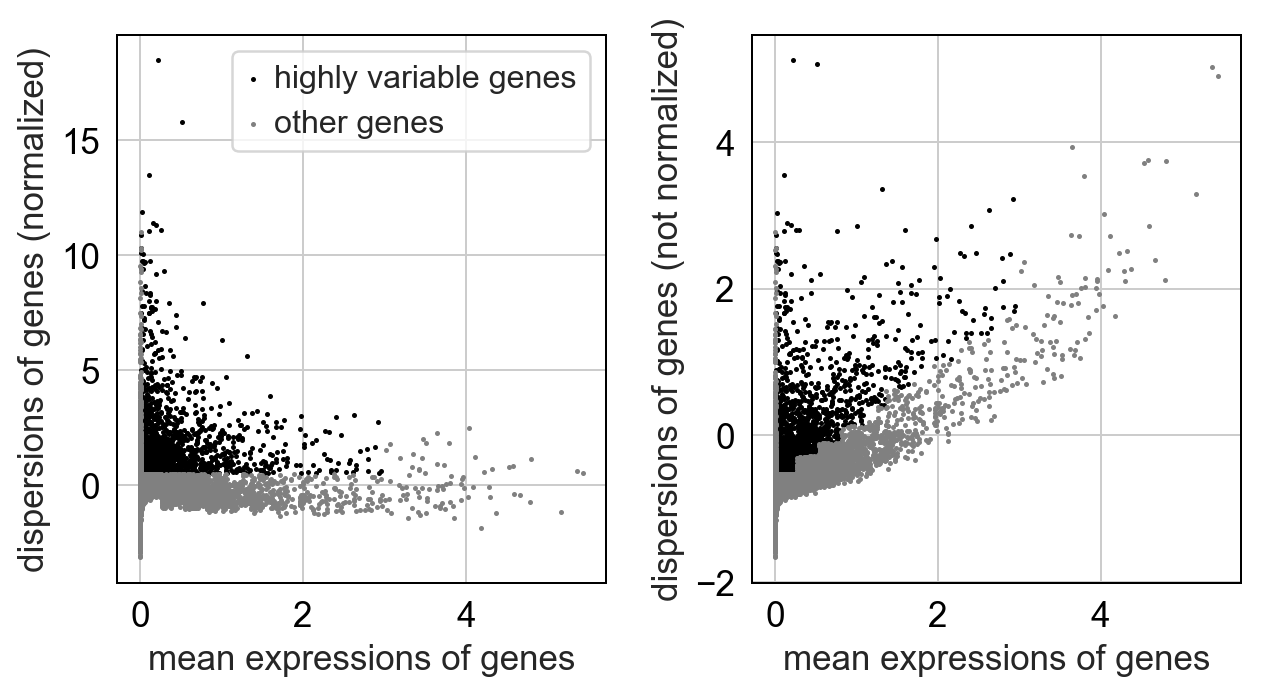

In [62]:
#Normalize gene counts
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#Store raw genes before filtering to highly variable genes
raw_matrix = adata.X
gene_names = np.array(adata.var.index)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)
#Filter to highly variable genes
adata = adata[:, adata.var['highly_variable']]

... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical


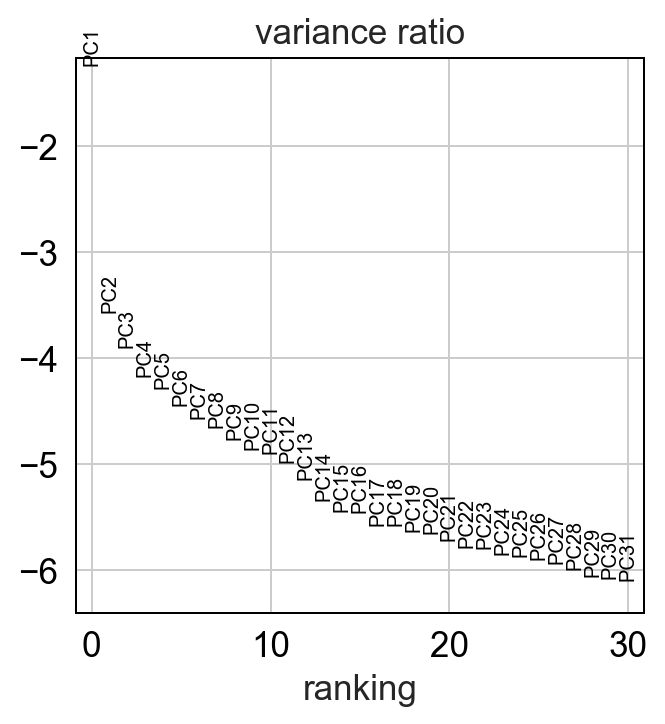

In [63]:
#Do PCA
adata.write(results_file)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00.99) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP


/Applications/EMAN2/envs/systemsbio/lib/python3.7/site-packages/scanpy/neighbors/umap/umap_.py:1173: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished (0:00:04.75) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Leiden clustering


... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical


    finished (0:00:00.74) --> found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)


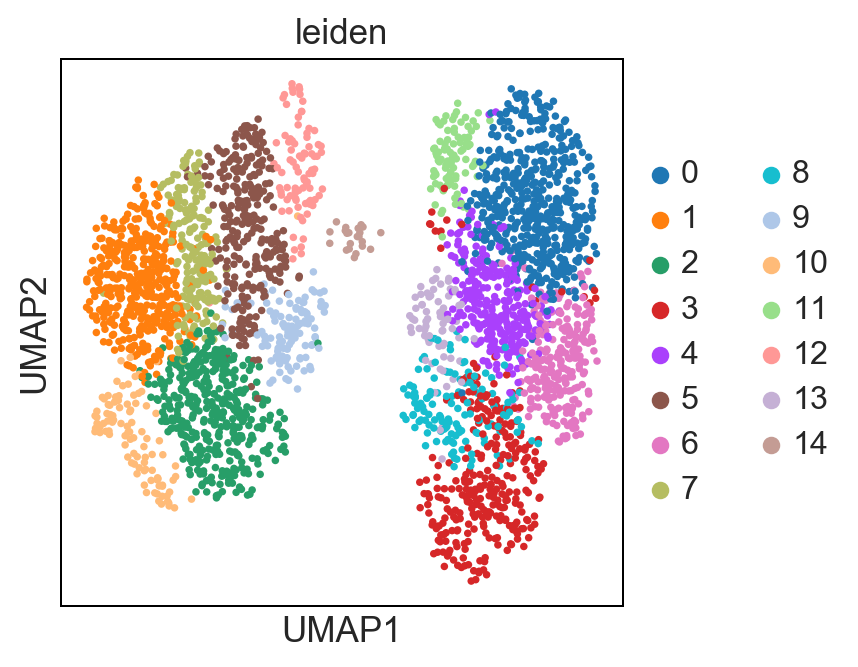

In [64]:
#Clustering and UMAP calculations
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata, min_dist = 2, gamma = 50)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])

In [65]:
## FOR ALL GRAPHS:
# substitute "pca" for "umap" in the function call to show the pca
# space graph instead of the umap graph.

... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical


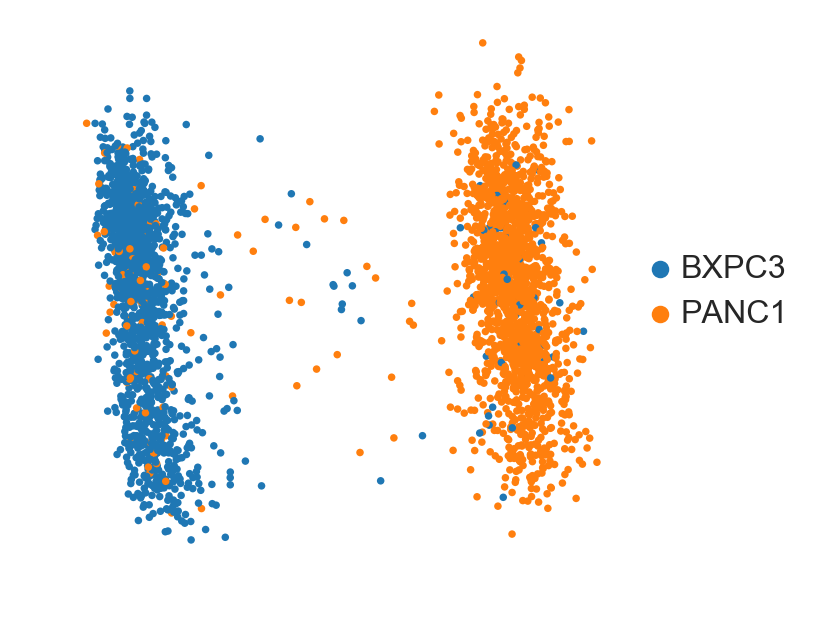

In [66]:
sc.pl.pca(adata, color='cell_ID',title='', frameon=False)

... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical


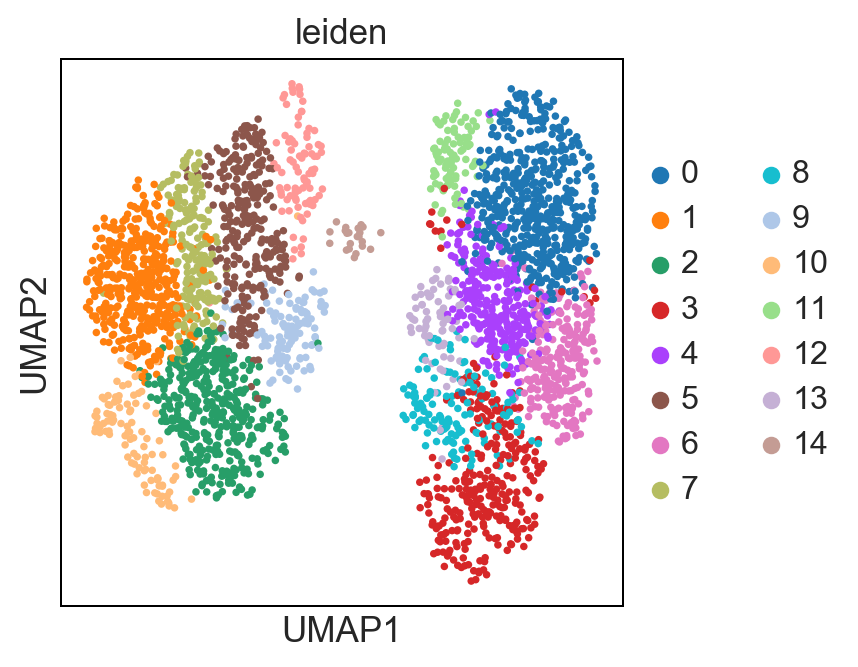

... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical


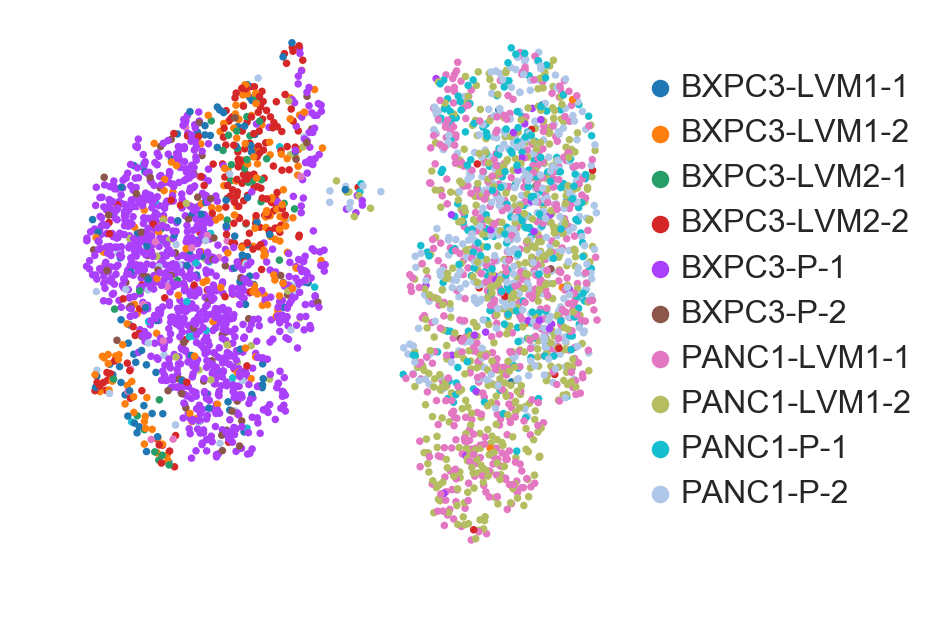

In [67]:
sc.pl.umap(adata, color=['leiden'])
sc.pl.umap(adata, color='pop_ID',title='', frameon=False)

Text(0.5, 1.0, 'Observation per Population Type')

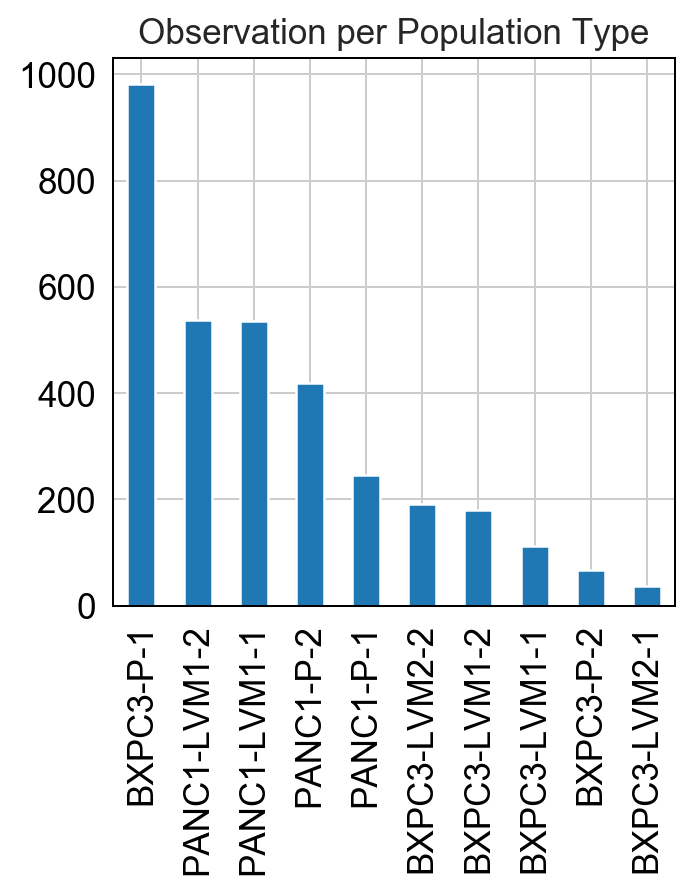

In [68]:
# Show observation counts per population
ax = adata.obs.pop_ID.value_counts().plot(kind='bar')
ax.set_title("Observation per Population Type")

In [69]:
x = adata.obs
def pickCategory(popText):
    if 'P-' in popText:
        return 'parental'
    if 'LVM1' in popText:
        return 'first_round'
    if 'LVM2' in popText:
        return 'second_round'
    else:
        return popText
x['experimental_category'] = [ pickCategory(c) for c in x.pop_ID ]

... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical
... storing 'experimental_category' as categorical


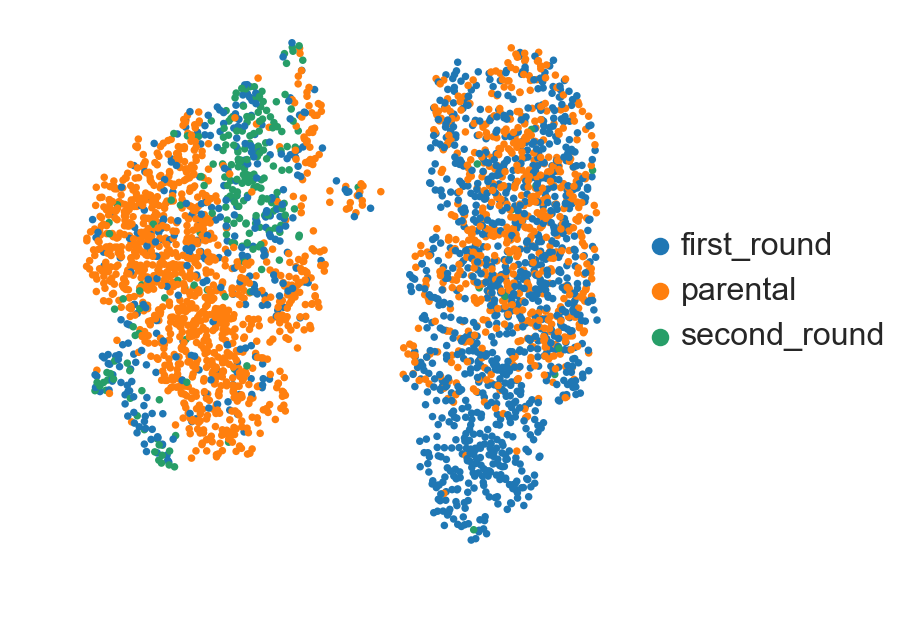

In [70]:
sc.pl.umap(adata, color='experimental_category',title='', frameon=False)

In [71]:
# Optional Plots 
#sc.pl.umap(adata[adata.obs.cell_ID == 'PANC1'], color='experimental_category',title='PANC1 Only', frameon=False)
#sc.pl.umap(adata[adata.obs.cell_ID == 'BXPC3'], color='experimental_category',title='BXPC3 Only', frameon=False)

## Individual Cell Line Clustering and UMAP

In [72]:
#Clustering and UMAP calculations on Cell Lines Individually

# PANC1
adata_panc1 = sc.pp.neighbors(adata[adata.obs.cell_ID == 'PANC1'], n_neighbors=15, n_pcs=30, copy=True)
sc.tl.umap(adata_panc1, min_dist = 2, gamma = 50)
sc.tl.leiden(adata_panc1)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00.63) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP


/Applications/EMAN2/envs/systemsbio/lib/python3.7/site-packages/scanpy/neighbors/umap/umap_.py:1173: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished (0:00:03.48) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Leiden clustering
    finished (0:00:00.26) --> found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)


... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical
... storing 'experimental_category' as categorical


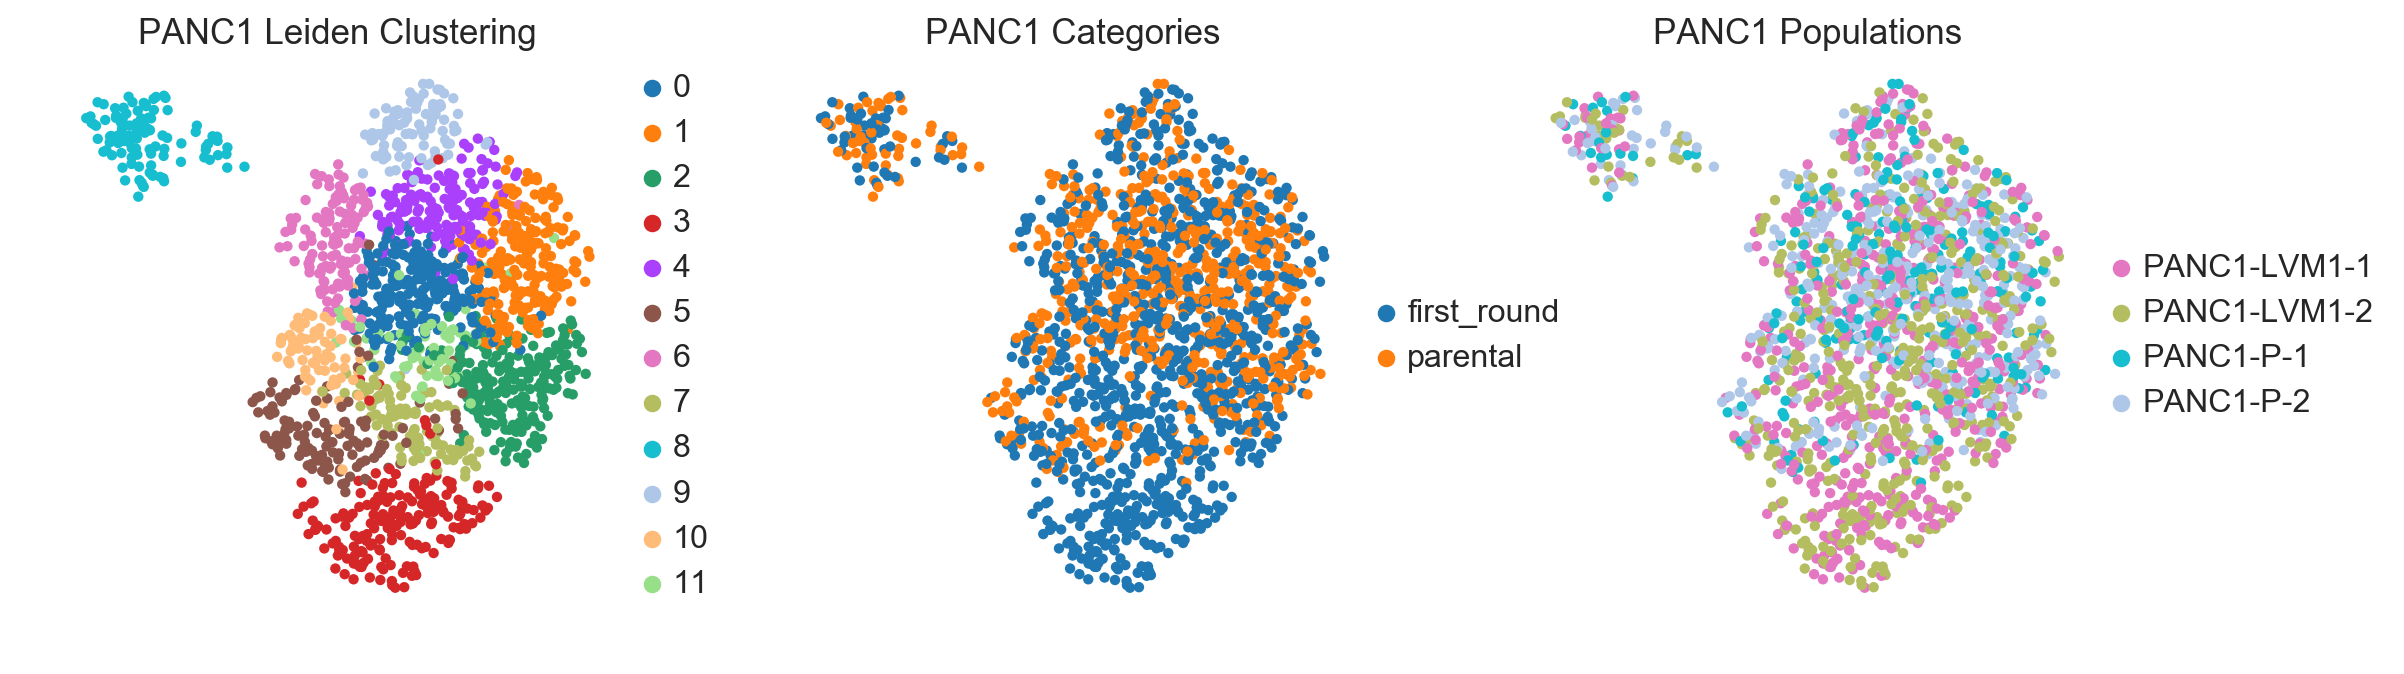

In [73]:
sc.pl.umap(adata_panc1, color=['leiden','experimental_category','pop_ID'],
           title=['PANC1 Leiden Clustering','PANC1 Categories','PANC1 Populations'],frameon=False)

In [74]:
# BXPC3
adata_bxpc3 = sc.pp.neighbors(adata[adata.obs.cell_ID == 'BXPC3'], n_neighbors=15, n_pcs=30, copy=True)
adata_bxpc3_p = adata_bxpc3[adata_bxpc3.obs.experimental_category == 'parental']
sc.tl.umap(adata_bxpc3, min_dist = 2, gamma = 50)
sc.tl.leiden(adata_bxpc3)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00.55) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP


/Applications/EMAN2/envs/systemsbio/lib/python3.7/site-packages/scanpy/neighbors/umap/umap_.py:1173: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished (0:00:02.28) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Leiden clustering
    finished (0:00:00.38) --> found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)


... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical
... storing 'experimental_category' as categorical


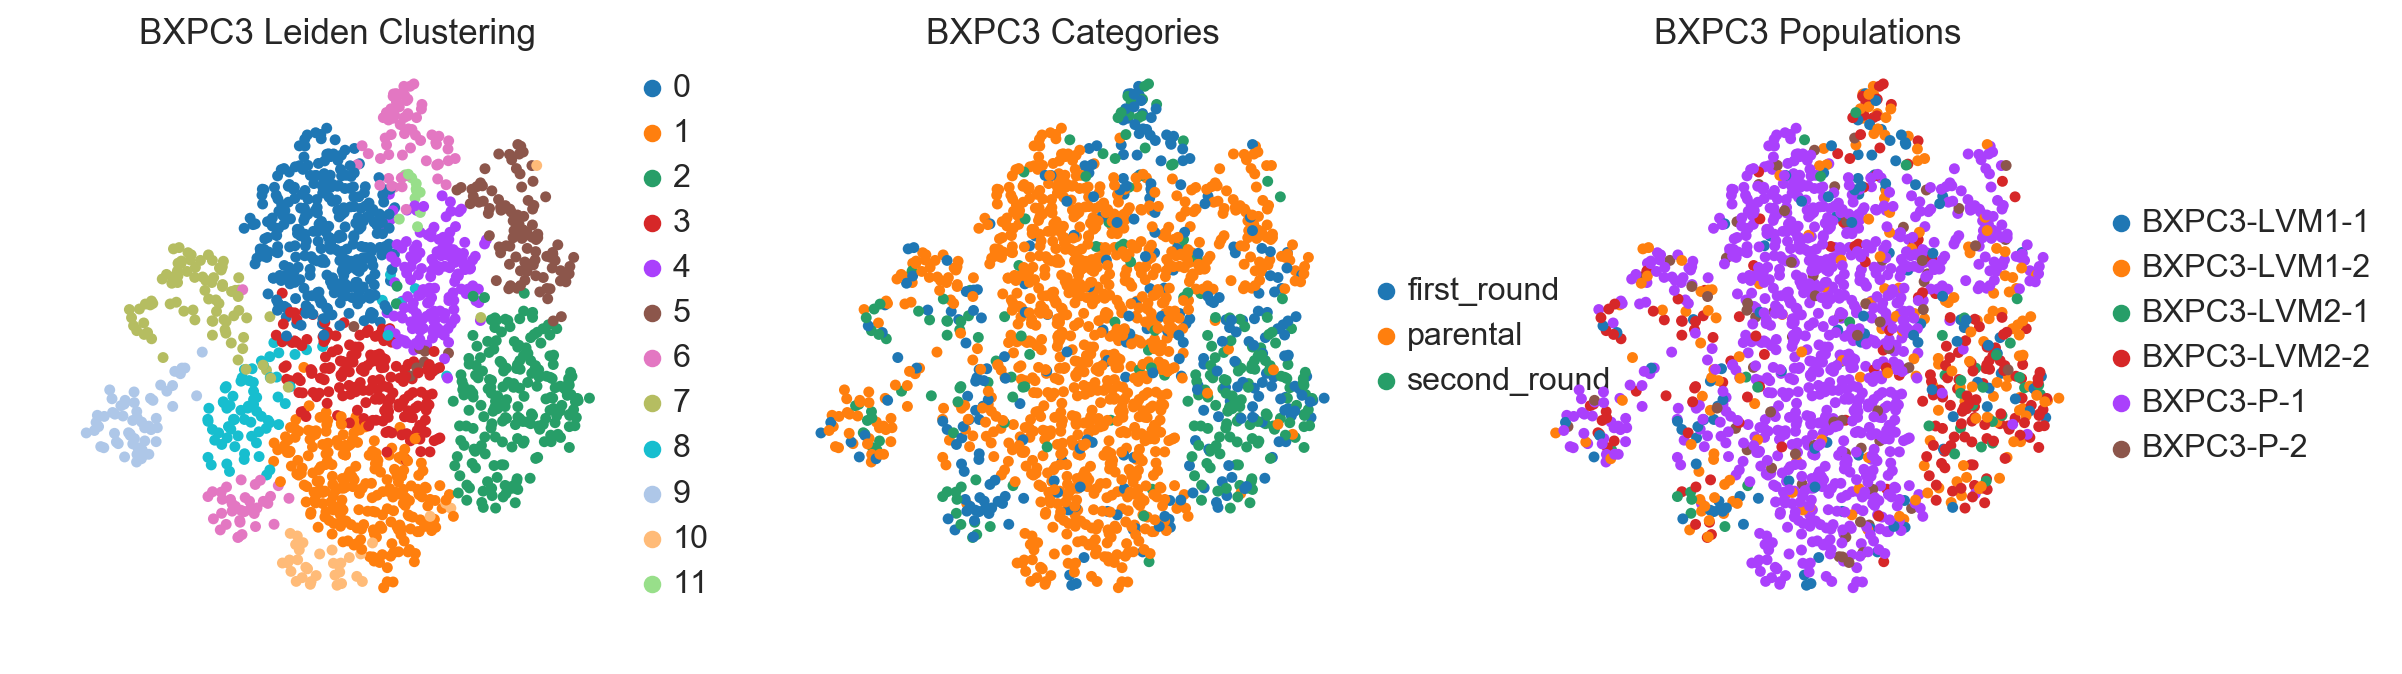

In [75]:
sc.pl.umap(adata_bxpc3, color=['leiden','experimental_category','pop_ID'],
           title=['BXPC3 Leiden Clustering','BXPC3 Categories','BXPC3 Populations'],frameon=False)

In [76]:
# # Create Data Subsets by Cell Line, with Leiden clustering
# # PANC1
# adata_panc1 = sc.pp.neighbors(adata[adata.obs.cell_ID == 'PANC1'], n_neighbors=15, n_pcs=30, copy=True)
# sc.tl.umap(adata_panc1, min_dist = 2, gamma = 50)
# sc.tl.leiden(adata_panc1)

In [77]:
# # BXPC3
# adata_bxpc3 = sc.pp.neighbors(adata[adata.obs.cell_ID == 'BXPC3'], n_neighbors=15, n_pcs=30, copy=True)
# sc.tl.umap(adata_bxpc3, min_dist = 2, gamma = 50)
# sc.tl.leiden(adata_bxpc3)

## Short Attempt at Rand Index Calculation

In [78]:
## Attempt at Rand Index Calculation

# rand index is trueP + trueN / (TP + FP + TN + FN)
# 'truth' is the metadata label for what cell type

# Highest-Level: Between Cell Types
    
counts_p = adata[adata.obs.cell_ID == 'PANC1'].obs.leiden.value_counts()
counts_b = adata[adata.obs.cell_ID == 'BXPC3'].obs.leiden.value_counts()

clusters_p = [] # which clusters count as 
clusters_b = []
for c in range(12):
    p = counts_p[str(c)]
    b = counts_b[str(c)]
    if p>b: # assign clusters to either 'panc1' or 'bxpc3' labeled clusters
        clusters_p.append(c)
    else:
        clusters_b.append(c)
# Uncomment to see results by cluster
#     print('cluster',c)
#     print('- PANC1:',p)
#     print('- BXPC3:',b)
# print("PANC1 Clusters:",clusters_p)
# print("BXPC3 Clusters:",clusters_b)
    

In [79]:
total_p = np.sum(counts_p)
total_b = np.sum(counts_b)
true_assigned_p = np.sum([ counts_p[str(c)] for c in clusters_p ])
true_assigned_b = np.sum([ counts_b[str(c)] for c in clusters_b ])
print("True PANC1, Positive PANC1",total_p, true_assigned_p)
print("True BXPC3, Positive BXPC3",total_b, true_assigned_b)

True PANC1, Positive PANC1 1738 1563
True BXPC3, Positive BXPC3 1569 1434


In [80]:
rand_index = (true_assigned_p + true_assigned_b) / (total_p + total_b)
rand_index

0.9062594496522528

# Part II: Differential Expression Analysis

## Determine Clusters of Interest

Clusters of interest will be determined by computing how many of the cells in each cluster corresponds to parental, LVM1, and LVM2, and setting a threshold. 

### BXPC3 Clusters

... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical
... storing 'experimental_category' as categorical


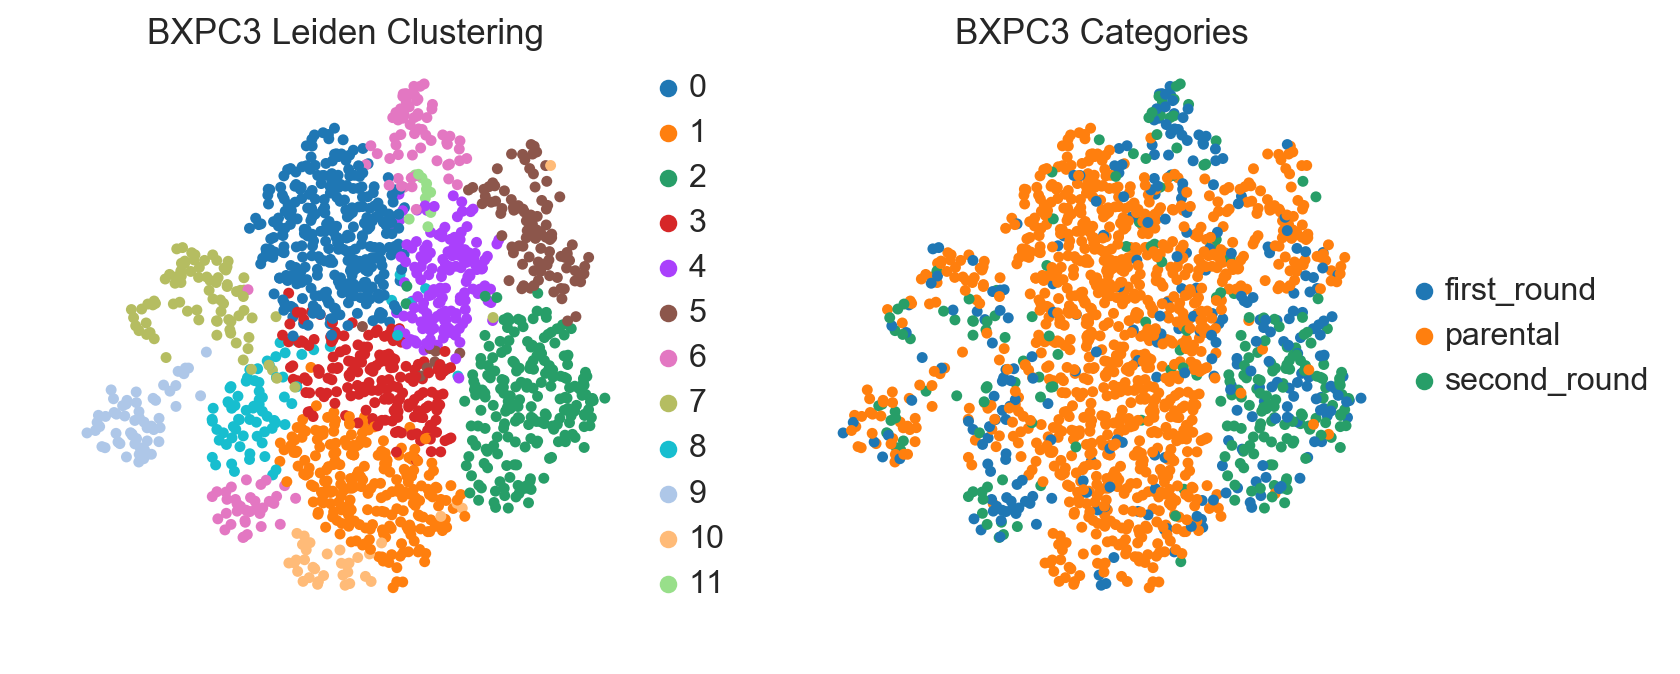

In [81]:
sc.pl.umap(adata_bxpc3, color=['leiden','experimental_category'],
           title=['BXPC3 Leiden Clustering','BXPC3 Categories'],frameon=False)

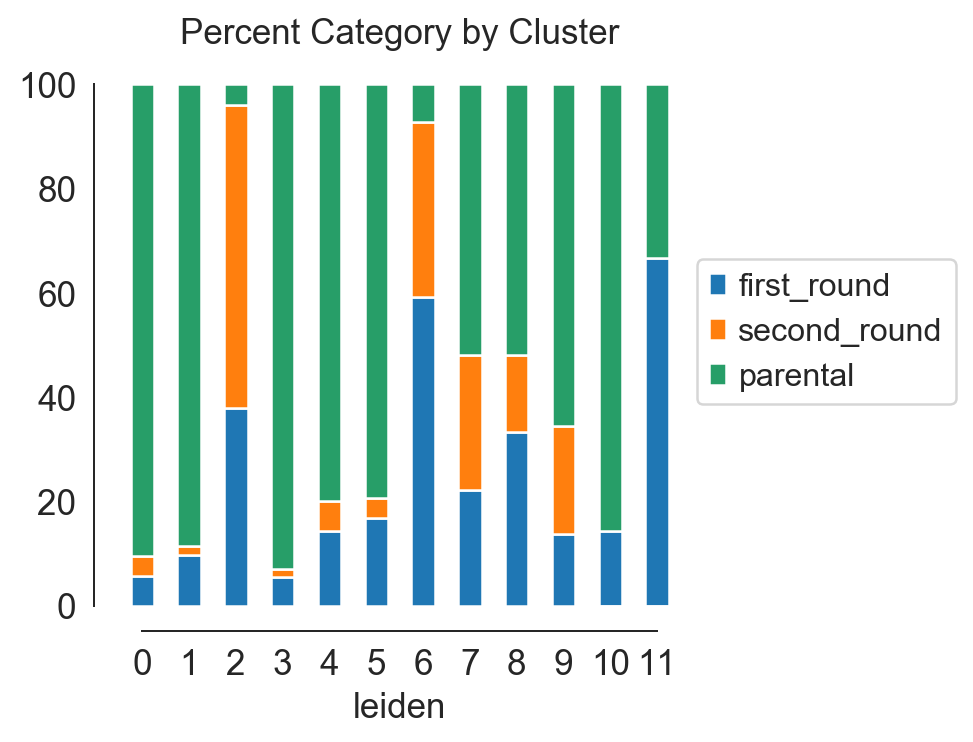

In [83]:
# Bar Plot to Quantify Observations Above
sns.set_style("white")
summary = adata_bxpc3.obs.groupby(['leiden','experimental_category'])['leiden'].count()
proportion = summary.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
df = pd.DataFrame(proportion)
df.columns= ['proportion']
df.reset_index(inplace=True)
pivot = df.pivot(index='leiden',columns='experimental_category',values='proportion')
plt = pivot.loc[:,['first_round','second_round','parental']].plot.bar(stacked=True,title='Percent Category by Cluster')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
sns.despine(offset=10, trim=True)
sns.despine()

Length of leiden cluster 11: 12 cells


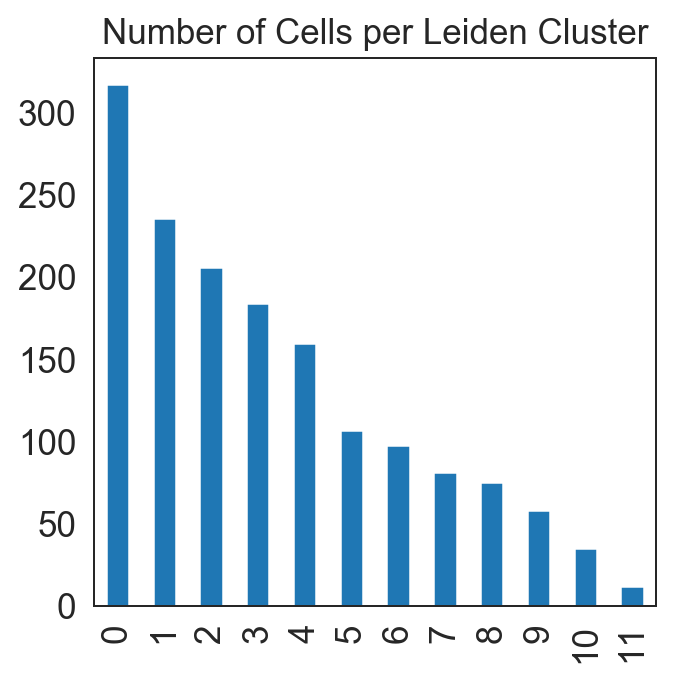

In [95]:
# Show observation counts per population
ax = adata_bxpc3.obs.leiden.value_counts().plot(kind='bar')
ax.set_title("Number of Cells per Leiden Cluster")
print("Length of leiden cluster 11:",len(adata_bxpc3[adata_bxpc3.obs['leiden'] == '11']),'cells')

Choose clusters 2 and 6 primarily; 11 is so small (12 cells) that it doesn't seem like we have sufficient statistical power to analyze it, but we *can* exclude it from the background if we want to remove the effect of those few LVM1 cells that are apparently distinct enough to be their own cluster?  

Notably, the primarily-parental clusters are 0, 1, 3, 4, 5, and 10. The middling clusters 7, 8, and 9 have almost 50% non-parental, although 9 could arguably be wrapped into the parental clusters.  

General conclusion:

- Metastatic clusters: 2,6  
- Parental clusters: 0,1,3,4,5,10

### PANC1  Clusters

... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical
... storing 'experimental_category' as categorical


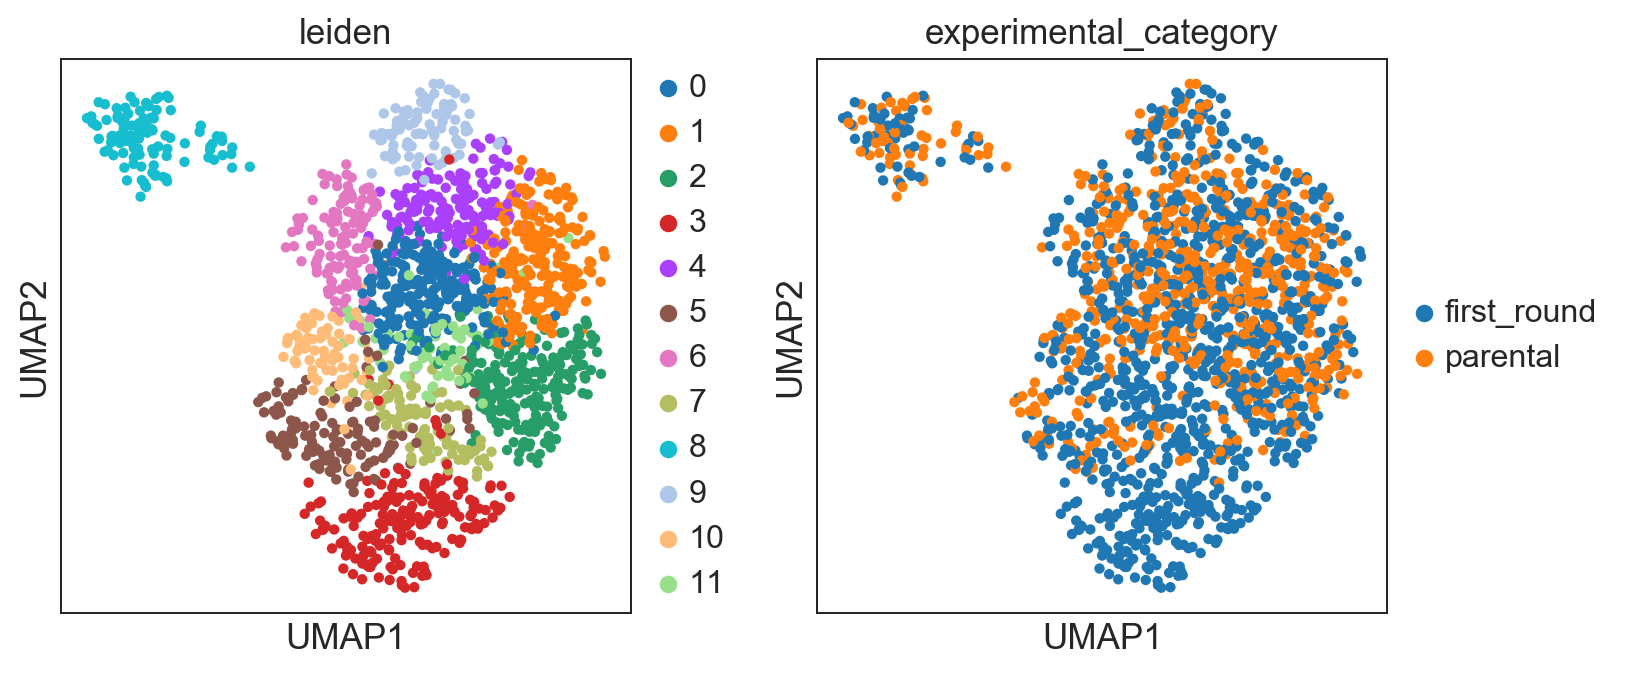

In [97]:
sc.pl.umap(adata_panc1, color=['leiden','experimental_category'])

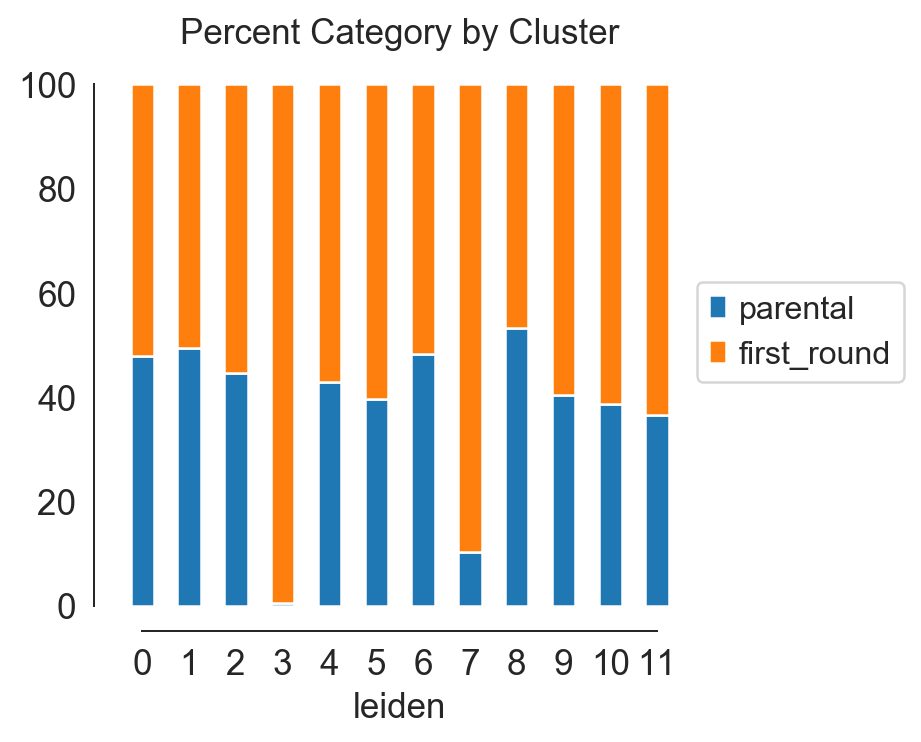

In [100]:
# Bar Plot to Quantify Observations Above
sns.set_style("white")
summary = adata_panc1.obs.groupby(['leiden','experimental_category'])['leiden'].count()
proportion = summary.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
df = pd.DataFrame(proportion)
df.columns= ['proportion']
df.reset_index(inplace=True)
pivot = df.pivot(index='leiden',columns='experimental_category',values='proportion')
plt = pivot.loc[:,['parental','first_round']].plot.bar(stacked=True,title='Percent Category by Cluster')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
sns.despine(offset=10, trim=True)
sns.despine()

Text(0.5, 1.0, 'Number of Cells per Leiden Cluster')

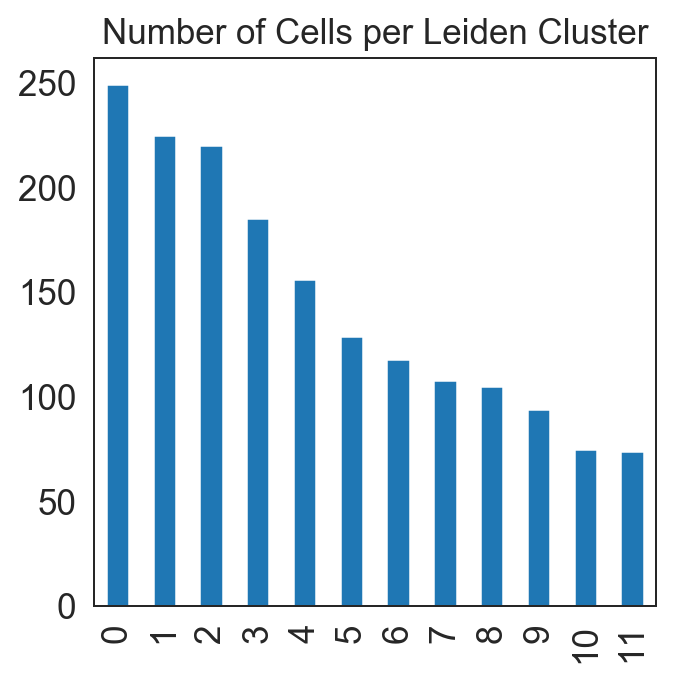

In [101]:
# Show observation counts per population
ax = adata_panc1.obs.leiden.value_counts().plot(kind='bar')
ax.set_title("Number of Cells per Leiden Cluster")

Choose clusters 3 and 7. Notably, there are NO clusters that are almost entirely parental, and the proportions are roughly the same for all the rest, so use them all as background. 

General conclusion:

- Metastatic clusters: 3,7  
- Background clusters: all others

In [103]:
adata_bxpc3.obs['is_highlighted'] = [l in ['2','6'] for l in adata_bxpc3.obs.leiden]
adata_panc1.obs['is_highlighted'] = [ l in ['3','7'] for l in adata_panc1.obs.leiden ]
adata_bxpc3.obs['cluster_type'] = ['leiden_'+l if l in ['2','6'] else 'background' if l in ['0','1','2','3','5','10'] else 'other' for l in adata_bxpc3.obs.leiden]
adata_panc1.obs['cluster_type'] = [ 'leiden_'+l if l in ['3','7'] else 'background' for l in adata_panc1.obs.leiden]

... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical
... storing 'experimental_category' as categorical
... storing 'cluster_type' as categorical


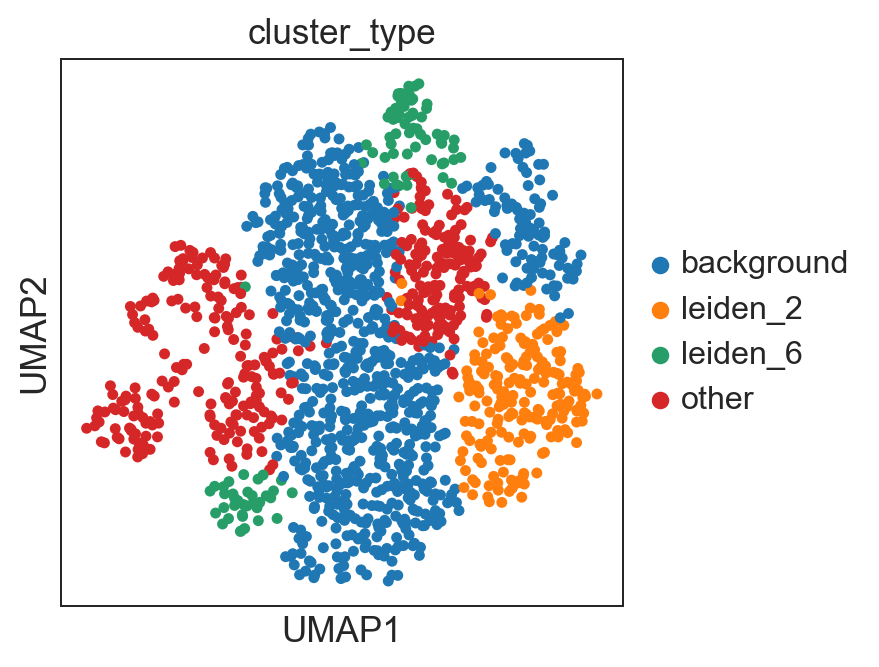

... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical
... storing 'experimental_category' as categorical
... storing 'cluster_type' as categorical


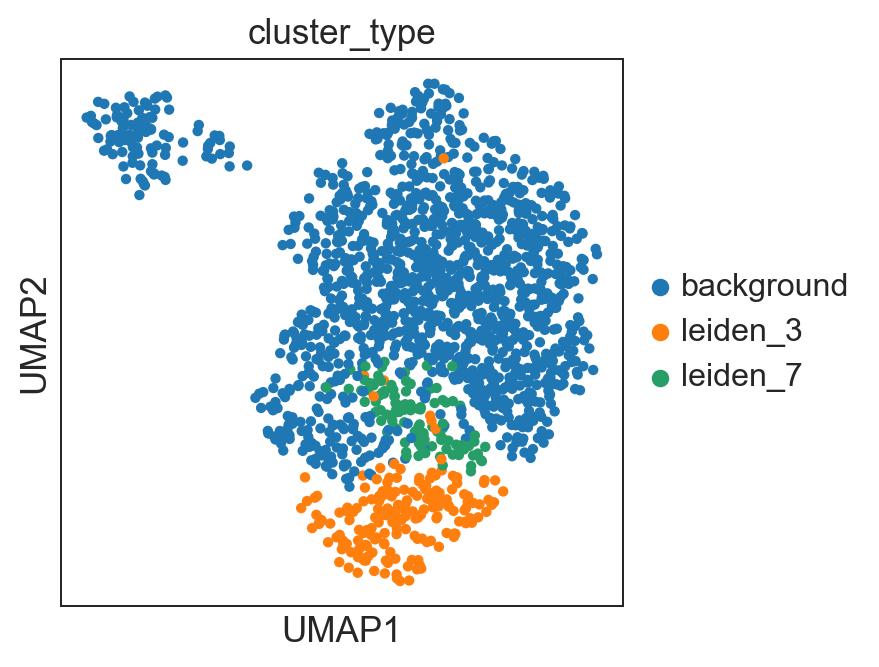

In [104]:
sc.pl.umap(adata_bxpc3, color=['cluster_type'])
sc.pl.umap(adata_panc1, color=['cluster_type'])

## Rank Genes by Ability to Distinguish Between Groups

#### BXPC3

In [105]:
# rank all 20k genes
bxpc3_ranked_genes = sc.tl.rank_genes_groups(adata_bxpc3,groupby='cluster_type',
            groups=['background','leiden_2','leiden_6'],reference='background',only_positive=False,
            copy=True,n_genes=len(adata_bxpc3.raw.var),method='wilcoxon')

ranking genes


... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical
... storing 'experimental_category' as categorical
... storing 'cluster_type' as categorical


    finished (0:00:05.26) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


In [110]:
bxpc3_ranked_genes.uns['rank_genes_groups']['params']

{'groupby': 'cluster_type',
 'reference': 'background',
 'method': 'wilcoxon',
 'use_raw': True,
 'corr_method': 'benjamini-hochberg'}

In [113]:
# create individual dataframes for each cluster
brg = bxpc3_ranked_genes.uns['rank_genes_groups']
group_ids = ('leiden_2','leiden_6')
# ^ based on read dtypes of the series in prg, leiden2 is index 0, leiden6 is index 1
names = list(zip(*brg['names']))
scores = list(zip(*brg['scores']))
logfoldchanges = list(zip(*brg['logfoldchanges']))
pvals = list(zip(*brg['pvals']))
pvals_adj = list(zip(*brg['pvals_adj']))

bxpc3_ranked_leiden2 = pd.DataFrame.from_dict({
    'scores':scores[0],
    'names': names[0],
    'logfoldchanges':logfoldchanges[0],
    'pvals':pvals[0],
    'pvals_adj':pvals_adj[0],
})
bxpc3_ranked_leiden6 =  pd.DataFrame.from_dict({
    'scores':scores[1],
    'names': names[1],
    'logfoldchanges':logfoldchanges[1],
    'pvals':pvals[1],
    'pvals_adj':pvals_adj[1],
})

In [117]:
# Filter for significant results
BXPC3_L2 = bxpc3_ranked_leiden2[(bxpc3_ranked_leiden2['pvals_adj'] <= 0.05) 
                                & abs(bxpc3_ranked_leiden2.logfoldchanges) >= 0.5]
BXPC3_L6 = bxpc3_ranked_leiden6[(bxpc3_ranked_leiden6['pvals_adj'] <= 0.05) 
                                & abs(bxpc3_ranked_leiden6.logfoldchanges) >= 0.5]

In [118]:
# Save results to csv
BXPC3_L2.to_csv("./bxpc3_leiden2_logfoldchangeGT50pct_genes.csv")
BXPC3_L6.to_csv("./bxpc3_leiden6_logfoldchangeGT50pct_genes.csv")

#### PANC1

In [119]:
# rank all 20k genes
panc1_ranked_genes = sc.tl.rank_genes_groups(adata_panc1,groupby='cluster_type',
            groups=['background','leiden_3','leiden_7'],reference='background',only_positive=False,
            copy=True,n_genes=len(adata_panc1.raw.var),method='wilcoxon')

ranking genes


... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical
... storing 'experimental_category' as categorical
... storing 'cluster_type' as categorical


    finished (0:00:05.66) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


In [122]:
panc1_ranked_genes.uns['rank_genes_groups']['params']

{'groupby': 'cluster_type',
 'reference': 'background',
 'method': 'wilcoxon',
 'use_raw': True,
 'corr_method': 'benjamini-hochberg'}

In [123]:
# create individual dataframes for each cluster
prg = panc1_ranked_genes.uns['rank_genes_groups']
group_ids = ('leiden_3','leiden_7')
# ^ based on read dtypes of the series in prg, leiden3 is index 0, leiden7 is index 1
names = list(zip(*prg['names']))
scores = list(zip(*prg['scores']))
logfoldchanges = list(zip(*prg['logfoldchanges']))
pvals = list(zip(*prg['pvals']))
pvals_adj = list(zip(*prg['pvals_adj']))

panc1_ranked_leiden3 = pd.DataFrame.from_dict({
    'scores':scores[0],
    'names': names[0],
    'logfoldchanges':logfoldchanges[0],
    'pvals':pvals[0],
    'pvals_adj':pvals_adj[0],
})
panc1_ranked_leiden7 =  pd.DataFrame.from_dict({
    'scores':scores[1],
    'names': names[1],
    'logfoldchanges':logfoldchanges[1],
    'pvals':pvals[1],
    'pvals_adj':pvals_adj[1],
})

In [124]:
# Filter for significant results
PANC1_L3 = panc1_ranked_leiden3[(panc1_ranked_leiden3['pvals_adj'] <= 0.05) 
                                & abs(panc1_ranked_leiden3.logfoldchanges) >= 0.5]
PANC1_L7 = panc1_ranked_leiden7[(panc1_ranked_leiden7['pvals_adj'] <= 0.05) 
                                & abs(panc1_ranked_leiden7.logfoldchanges) >= 0.5]

In [125]:
# Save results to csv
PANC1_L3.to_csv("./panc1_leiden3_logfoldchangeGT50pct_genes.csv")
PANC1_L7.to_csv("./panc1_leiden7_logfoldchangeGT50pct_genes.csv")

... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical
... storing 'experimental_category' as categorical
... storing 'cluster_type' as categorical
... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical
... storing 'experimental_category' as categorical
... storing 'cluster_type' as categorical


saving figure to file ./figures/stacked_violin_bxpc3.pdf


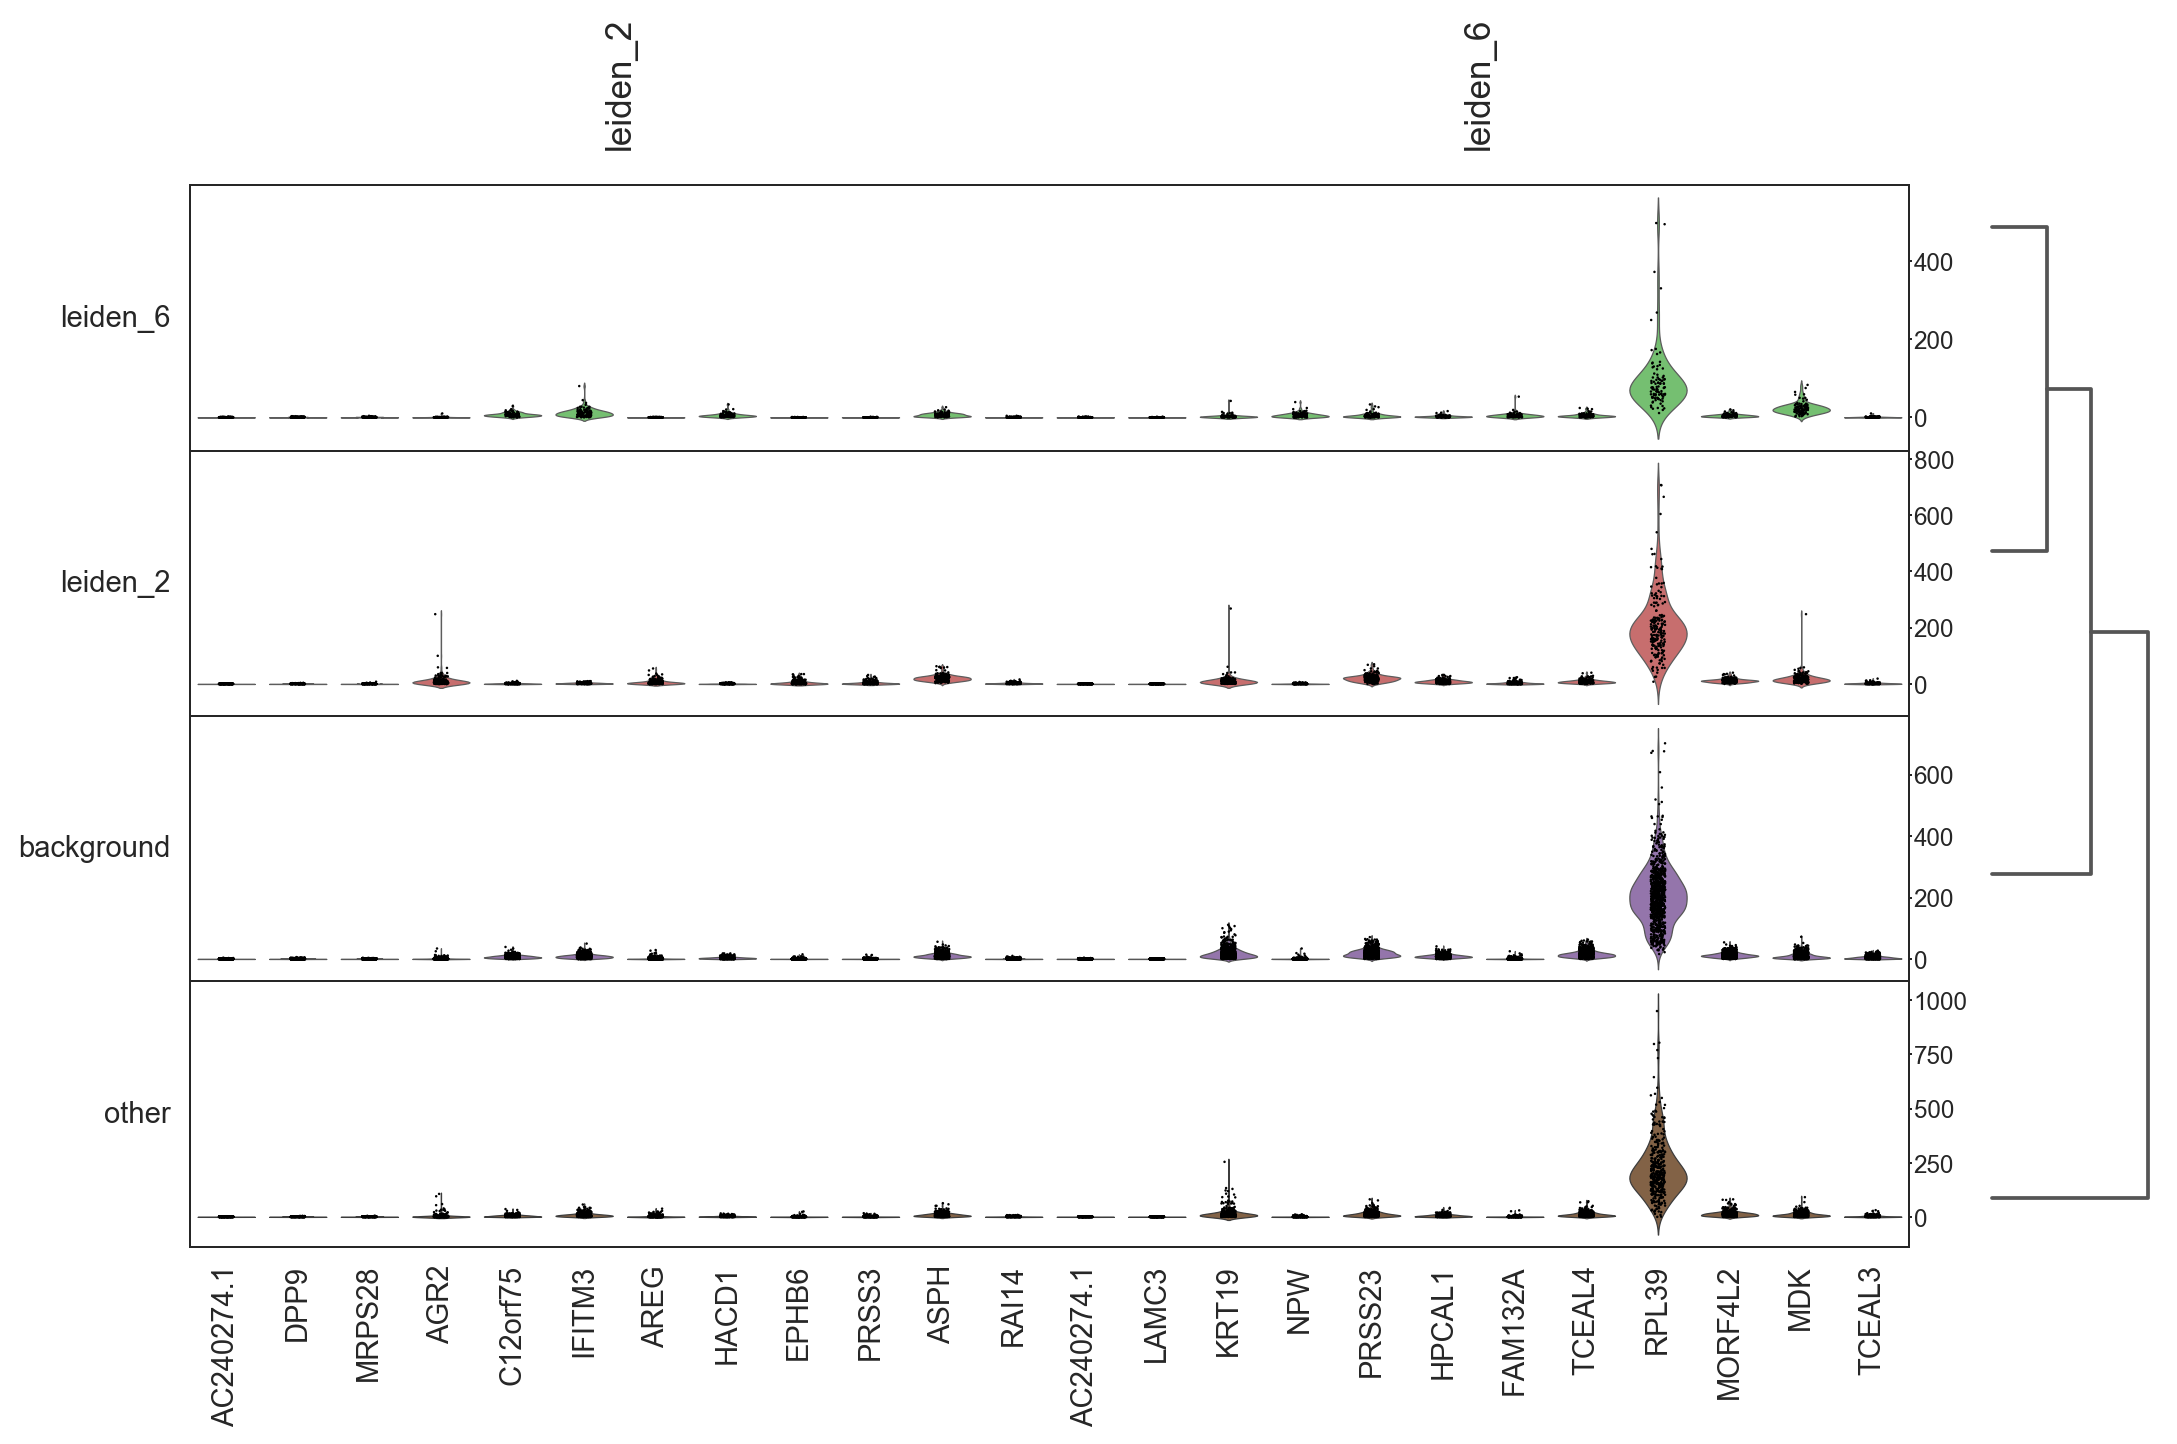

In [126]:
# Violinplot for fun
sc.pl.rank_genes_groups_stacked_violin(bxpc3_ranked_genes,n_genes=12,
                                     save='_bxpc3',sharey=True,
                                      jitter=True,stripplot=True,figsize=(14,8))

... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical
... storing 'experimental_category' as categorical
... storing 'cluster_type' as categorical
... storing 'pop_ID' as categorical
... storing 'cell_ID' as categorical
... storing 'leiden' as categorical
... storing 'experimental_category' as categorical
... storing 'cluster_type' as categorical


saving figure to file ./figures/stacked_violin_panc1.pdf


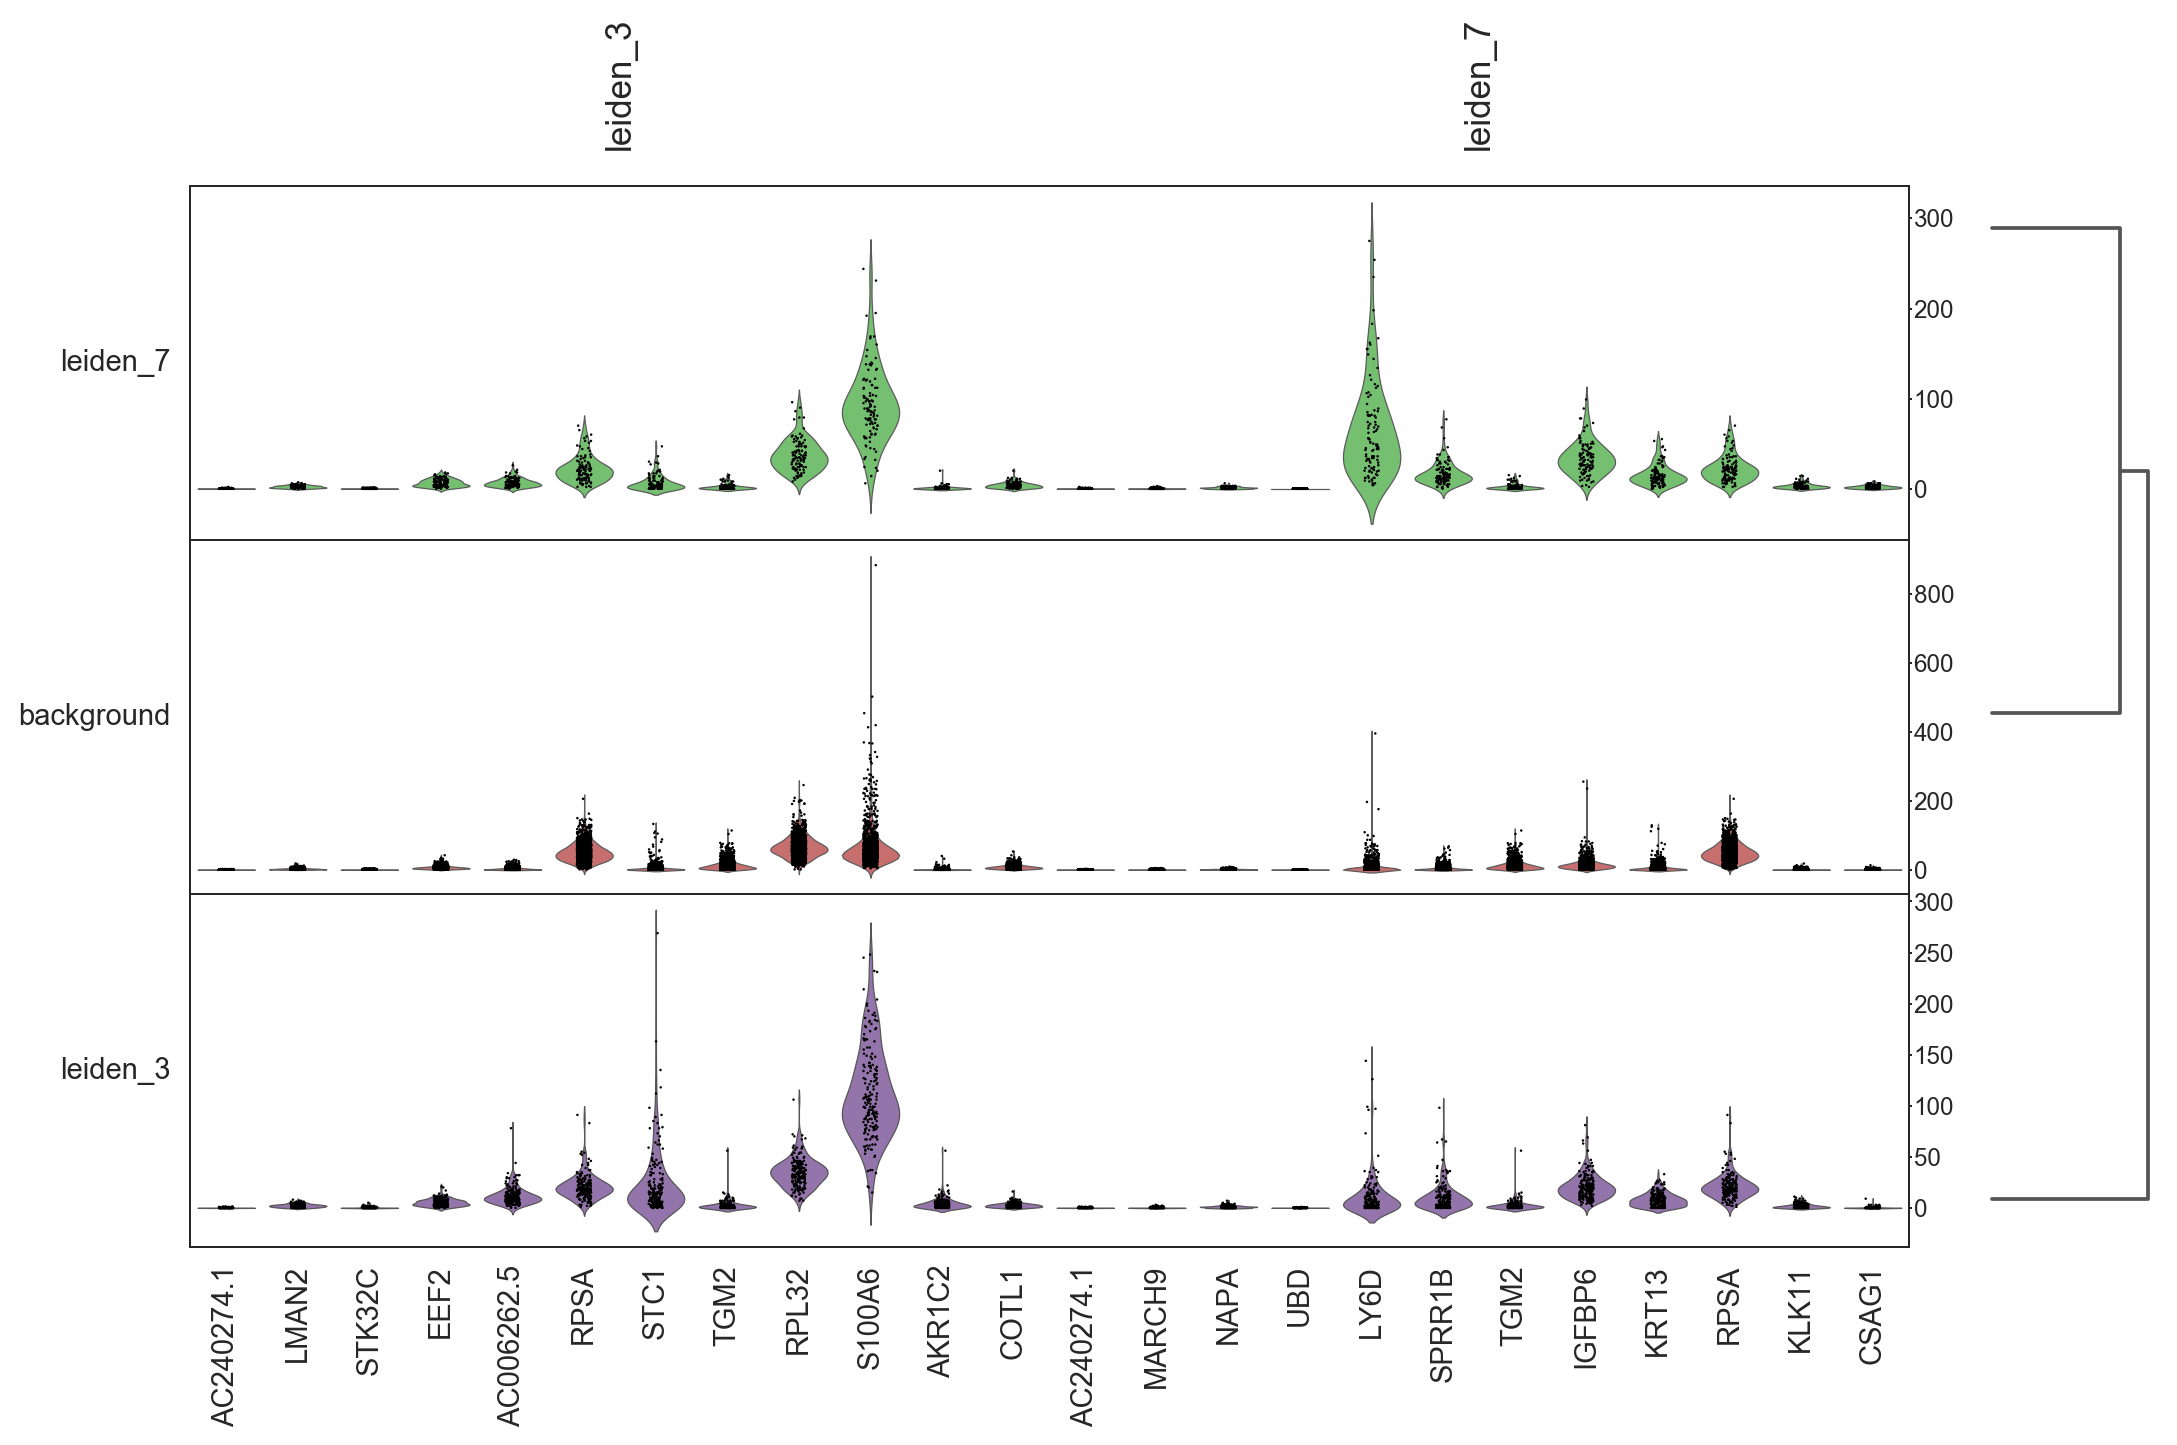

In [127]:
sc.pl.rank_genes_groups_stacked_violin(panc1_ranked_genes,n_genes=12,
                                     save='_panc1',sharey=True,
                                      jitter=True,stripplot=True,figsize=(14,8))